# Определение возраста покупателей

**Описание проекта**    

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:    

+ анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
+ контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта:**     

Построить модель, которая по фотографии определит приблизительный возраст человека.

**Этапы выполнению проекта:**      

1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитать её качество.

In [1]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", None)

## Исследовательский анализ данных

In [2]:
df_labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df_labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [4]:
df_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
df_labels['real_age'].value_counts()

30     317
25     315
27     229
26     226
28     217
23     213
24     211
18     193
16     193
19     180
22     179
20     178
32     174
40     167
29     164
17     163
34     156
50     156
1      149
35     147
37     144
33     144
21     143
31     129
15     128
14     125
38     124
36     122
39     107
4      101
42      99
41      98
44      96
47      93
2       88
45      88
5       87
43      85
13      79
52      76
60      75
49      74
46      74
51      70
6       68
7       67
48      66
12      56
58      54
11      51
55      51
70      50
53      45
10      45
54      44
8       44
56      41
59      41
57      37
65      36
9       34
80      31
62      28
61      28
3       25
64      23
90      21
63      20
66      18
69      18
67      18
75      17
68      15
72      13
85      12
73      10
71      10
77       8
84       8
76       7
74       6
79       6
87       6
94       5
82       5
89       4
86       3
78       3
81       3
83       3
88       3

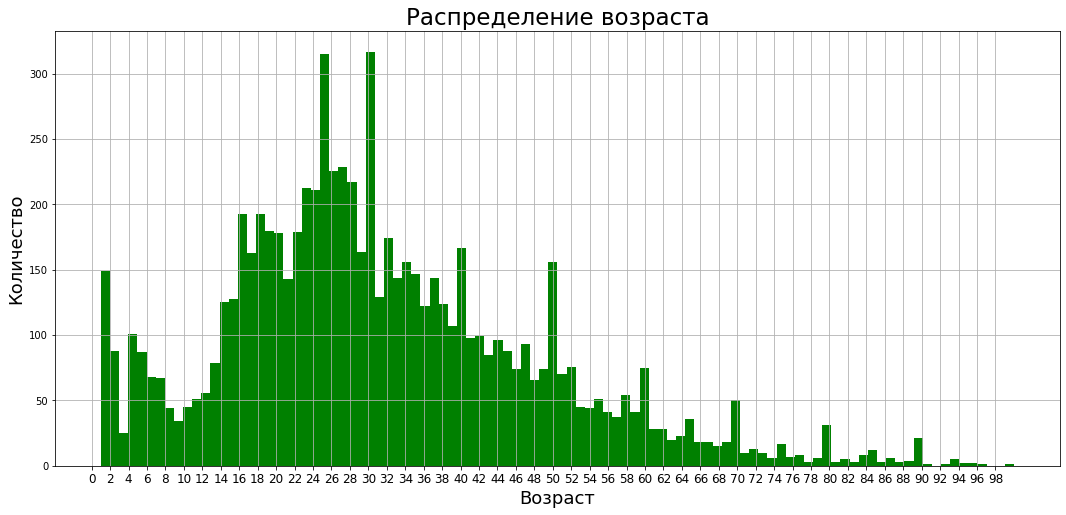

In [7]:
plt.figure(figsize=(18, 8))
df_labels['real_age'].hist(bins=100, color='g')
plt.xlabel('Возраст', fontsize=18)
plt.ylabel('Количество', fontsize=18)
plt.title('Распределение возраста', fontsize=23)
plt.xticks(range(0, 100, 2), fontsize=12);

In [8]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


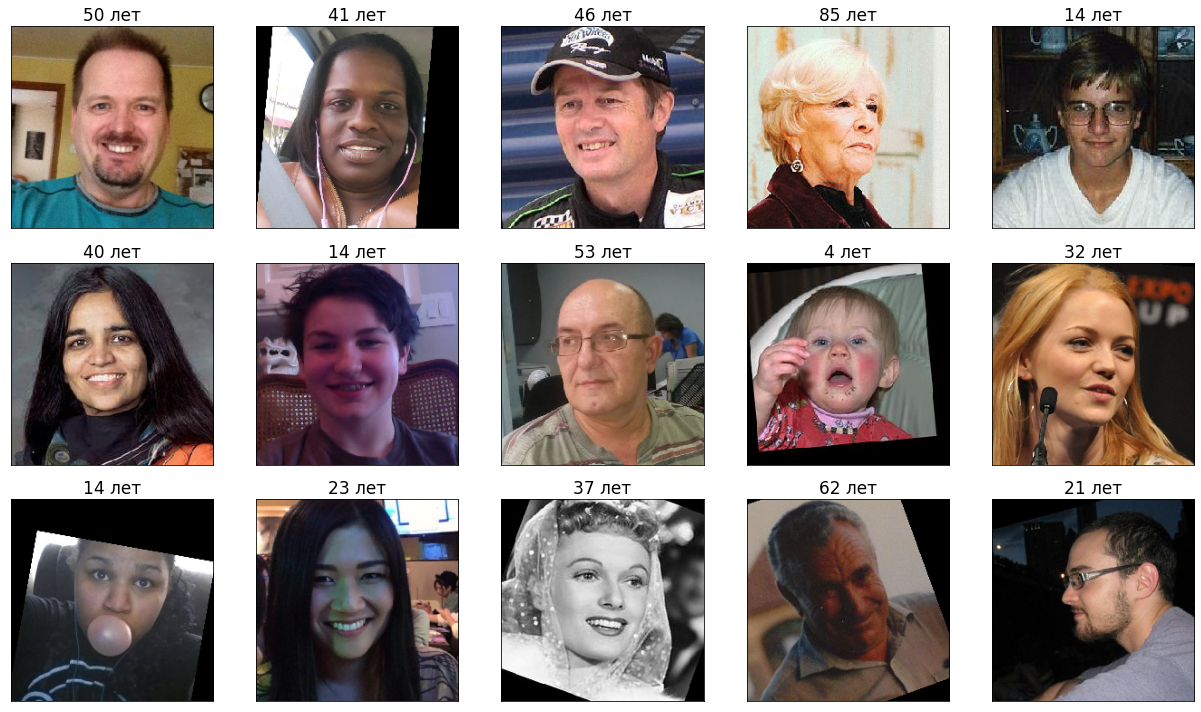

In [9]:
X, y = next(datagen_flow)
fig = plt.figure(figsize=(18, 10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(X[i])
    plt.title(f'{y[i]} лет', fontsize=17)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout();

**Вывод:**  

+ Возраст людей от 1 до 100.   
+ Данные распределены неравномерно, распределение вытянуто вправо.     
+ 25-квантиль 20 лет, 75-квантиль 41 год. Медиана = 29 лет, среднее = 31.2 года.       
+ Больше всего фотографий людей в возрасте от 23 до 30. Меньше всего после 60.     
+ Следовательно на данных после 60 лет модель будет обучаться не очень хорошо.     
+ Также отрицательным фактором может являтся поворот некоторых фотографий, разное освещение, фото черно-белого цвета.

## Обучение модели

**Задача:** 

**Построить и обучить свёрточную нейронную сеть на датасете с фотографиями людей. Добиться значения MAE на тестовой выборке не больше 8.** 

**В статье о датасете, с которым вы работаете, значение MAE равно 5.4 — если вы получите MAE меньше 7, это будет отличный результат!**

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):
    df_labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
    
    return train_gen_flow

def load_test(path):
    df_labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1/255.)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    
    return test_gen_flow

def create_model(input_shape):
    
    optimizer = Adam(learning_rate=0.0002)
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(64, activation='relu')) 
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, 
                batch_size=None, epochs=28, 
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

Epoch 1/28     
178/178 - 72s - loss: 207.7381 - mae: 10.4769 - val_loss: 606.8289 - val_mae: 19.6374    
Epoch 2/28      
178/178 - 52s - loss: 70.0127 - mae: 6.3452 - val_loss: 522.1449 - val_mae: 17.7632     
Epoch 3/28    
178/178 - 52s - loss: 35.5080 - mae: 4.5695 - val_loss: 315.5382 - val_mae: 13.1819    
Epoch 4/28     
178/178 - 52s - loss: 21.4986 - mae: 3.5881 - val_loss: 122.4691 - val_mae: 8.4145     
Epoch 5/28    
178/178 - 51s - loss: 14.3276 - mae: 2.9091 - val_loss: 84.5934 - val_mae: 6.9833    
Epoch 6/28     
178/178 - 52s - loss: 12.2268 - mae: 2.6830 - val_loss: 81.9107 - val_mae: 7.0304    
Epoch 7/28    
178/178 - 52s - loss: 10.6632 - mae: 2.4751 - val_loss: 79.5789 - val_mae: 6.6803    
Epoch 8/28    
178/178 - 51s - loss: 8.6862 - mae: 2.2318 - val_loss: 66.9694 - val_mae: 6.1226    
Epoch 9/28    
178/178 - 52s - loss: 8.5206 - mae: 2.1722 - val_loss: 70.4974 - val_mae: 6.2976    
Epoch 10/28    
178/178 - 50s - loss: 7.8752 - mae: 2.1147 - val_loss: 74.9999 - val_mae: 6.7819    
Epoch 11/28    
178/178 - 48s - loss: 7.3952 - mae: 2.0485 - val_loss: 69.9844 - val_mae: 6.3909    
Epoch 12/28     
178/178 - 48s - loss: 7.1585 - mae: 2.0288 - val_loss: 73.8234 - val_mae: 6.5747    
Epoch 13/28     
178/178 - 48s - loss: 7.1359 - mae: 2.0281 - val_loss: 64.4699 - val_mae: 6.0954    
Epoch 14/28    
178/178 - 49s - loss: 7.6461 - mae: 2.0691 - val_loss: 67.4475 - val_mae: 6.2611    
Epoch 15/28     
178/178 - 71s - loss: 7.9836 - mae: 2.1317 - val_loss: 64.1430 - val_mae: 5.9376     
Epoch 16/28      
178/178 - 71s - loss: 7.3435 - mae: 2.0602 - val_loss: 78.3802 - val_mae: 6.4506     
Epoch 17/28     
178/178 - 58s - loss: 6.6302 - mae: 1.9461 - val_loss: 72.1814 - val_mae: 6.5764     
Epoch 18/28    
178/178 - 45s - loss: 7.3728 - mae: 2.0338 - val_loss: 68.5305 - val_mae: 6.1926    
Epoch 19/28     
178/178 - 52s - loss: 7.2947 - mae: 2.0242 - val_loss: 66.6023 - val_mae: 6.1311    
Epoch 20/28     
178/178 - 50s - loss: 6.2659 - mae: 1.8974 - val_loss: 65.4213 - val_mae: 6.1968    
Epoch 21/28    
178/178 - 39s - loss: 5.9321 - mae: 1.8372 - val_loss: 65.0243 - val_mae: 6.0477    
Epoch 22/28    
178/178 - 41s - loss: 5.2356 - mae: 1.7405 - val_loss: 69.0930 - val_mae: 6.2280    
Epoch 23/28     
178/178 - 40s - loss: 5.2416 - mae: 1.7325 - val_loss: 70.2125 - val_mae: 6.3131    
Epoch 24/28    
178/178 - 38s - loss: 5.3448 - mae: 1.7545 - val_loss: 65.5549 - val_mae: 6.0751    
Epoch 25/28     
178/178 - 40s - loss: 5.4985 - mae: 1.7604 - val_loss: 63.6071 - val_mae: 6.0802     
Epoch 26/28     
178/178 - 38s - loss: 6.4506 - mae: 1.8935 - val_loss: 68.3943 - val_mae: 6.2126     
Epoch 27/28     
178/178 - 38s - loss: 6.7291 - mae: 1.9421 - val_loss: 72.1419 - val_mae: 6.2267     
Epoch 28/28      
178/178 - 44s - loss: 6.4175 - mae: 1.9204 - val_loss: 62.7031 - val_mae: 5.8620     
    
60/60 - 10s - loss: 62.7031 - mae: 5.8620     
Test MAE: 5.8620    


**Вывод:**     

+ Мы обучили модель на архитектуре ResNet50.       
+ Получили 1.92 на трейне и 5.86 на тесте, что соответствует условию.    

## Анализ обученной модели

У нас было два пункта пожеланий от заказчика:    

1. анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. контролировать добросовестность кассиров при продаже алкоголя.   

Мы построили модель, которая по фотографии определит приблизительный возраст человека. С первым пунктом модель, я думаю, справится. По второму пункту - очень большой вопрос. Учитывая, ошибку в 6 лет, модель не сможет помочь при продаже алкоголя и табака, где возраст нужно определить, относительно определённого порога.

<div style='border: 5px solid blue; padding: 20px; border-radius: 20px; font-weight: bold'>
    <p style='text-align: center; font-size: 17px'>Осмелюсь сделать предложения по улучшению модели:</p>
<p>1. В датасете довольно много фотографий годовалых детей (149 шт.), также много (около 100) фотографий детей 2, 4 и 5 лет. Это постоянные покупатели элитного алкоголя&#x1F923;&#x1F923;&#x1F923; Вообщем я бы убрал из датасета фотографии до 7 лет. Вряд ли годовалые дети приходят за покупками.</p>      
<p>2. В папке с фотографиями я бы отделил фото людей старше 50 лет, а также в возрасте 7-14 лет, провёл бы аугментацию фото, а затем бы присоединил бы к остальным фотографиям. И уже после этого обучал бы модель.</p>
<p>3. Ещё, как вариант, можно разбить покупателей на категории (5-10 лет), чтобы проанализировать покупки и более эффективно предлагать товары для этой возрастной категории. Это больше в сторону маркетинга, но также может помочь при обучении модели.</p>
<p>4. Можно ещё, конечно, обойтись без модели. А с фотофиксации людей сравнивать их фото с базами данных, в которых указан их возраст. Ой... похоже, меня понесло...&#x1F606;</p>
<p>P.S.: Мне не очень понятны, конечно, сами фотографии. В описании сказано: "Фотофиксация в прикассовой зоне поможет определять возраст клиентов". Если это будет так, то качество модели будет значительно выше (одинаковый фон, размер фото, освещение и т.д и т.п.). А в данном датасете, как будто покупатели принесли свои фото на память сумермаркету - кто на кухне, кто на пляже, кто с микрофоном, у кого-то церно-белые фотографии...</p>

</div>

## Общий вывод

1. Мы провели исследовательский анализ набора фотографий и выявили, что:
    + Возраст людей от 1 до 100.   
    + Данные распределены неравномерно, распределение вытянуто вправо.     
    + 25-квантиль 20 лет, 75-квантиль 41 год. Медиана = 29 лет, среднее = 31.2 года.       
    + Больше всего фотографий людей в возрасте от 23 до 30. Меньше всего после 60.     
    + Следовательно на данных после 60 лет модель будет обучаться не очень хорошо.     
    + Также отрицательным фактором может являтся поворот некоторых фотографий, разное освещение, фото черно-белого цвета.
2. Подготовили данные к обучению.
    + разделили данные на обучающую и тестовую выборки.
    + написали функции для создания и обучения модели.
3. Обучили нейронную сеть и рассчитали её качество.
    + обучили свёрточную нейронную сеть на архитектуре ResNet50. 
    + Добились значения MAE на тестовой выборке не больше 8 (5.86).